# Hidden Markov Model 

In [1]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from mixture_model import *

np.set_printoptions(precision=4, suppress=True)
%load_ext autoreload
%autoreload 2

#### Load Data 

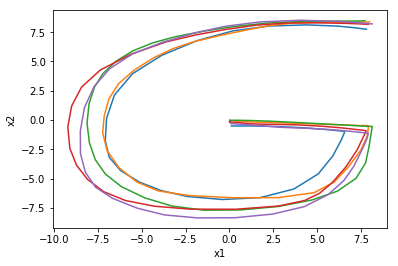

In [15]:
ROOT = '../python_data/2Dletters/'
n_samples = 5
raw_data = np.load(ROOT + 'G.npy')[:n_samples]
raw_data = raw_data.transpose([0,2,1])

#subsample the trajectories to 50 time steps per trajectory
data = []
for data_i in raw_data:
    data.append(subsample(data_i,50))
data= np.array(data)

#plot data
for data_i in data:
    plt.plot(data_i[:,0], data_i[:,1],'-')
plt.xlabel('x1')
plt.ylabel('x2')

T = data.shape[1] #the number of timesteps for each trajectory
D = data.shape[2] #the number of dimensions

### Objective: 
To construct an HMM based on the trajectory of the points $\{x_1,x_2\}$. Each trajectory consists of $T$ time steps.

Our 'observation' variable is $x = {\{x_1,x_2\}} \in \mathbb{R}^2$

We assume that $x$ is generated from a Gaussian distribution, the parameters of which depend on the hidden variables $z$. i.e., 

$$p(x|z=1) = \mathcal{N}(\mu_1, \Sigma_1)$$

$$p(x|z=2) = \mathcal{N}(\mu_2, \Sigma_2)$$

$$...$$ 

$$p(x|z=K) = \mathcal{N}(\mu_K, \Sigma_K)$$

In other words, we would like to estimate the probability of $x$ as a mixture of Gaussians, and we use HMM to model the transition probability from one mixture component to another along the trajectory. 

When training the HMM, we need to calculate the parameters of the mixture of Gaussians $\{\pi_k, \mu_k, \Sigma_k \}$, as well as the transition probability matrix. 

Note that different from the standard GMM, $\pi_k$ here denotes the _initial_ probability distribution of the mixture components.  

### Construct an HMM 

In [16]:
hmm = HMM(D= 2, K=5, M = 5, N = T) #use 5 mixture components, 5 samples and 200 time steps

#### Manual Initialisation of the mixture components

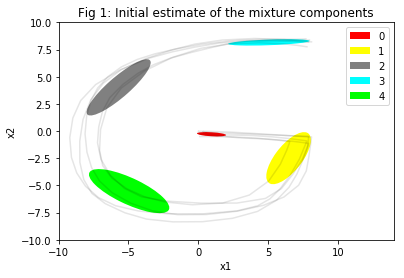

In [17]:
hmm.init_kmeans(data.reshape(-1,D))
#hmm.init_random(data.reshape(-1,D))
#hmm.init_kbins(data.reshape(-1,D))

#plot the mixture components
colors = [[1.,0.,0.],[1.,1.,0.],[0.5,0.5,0.5],[0.,1.,1.],[0.,1.,0.],[0.,0.,1.],]
fig,ax = plt.subplots()
plot_GMM(hmm.means_, hmm.covariances_,ax,labels=['0','1','2','3','4','5'],colors=colors)
plt.axis([-10,14,-10,10])
plt.title('Fig 1: Initial estimate of the mixture components')
plt.legend(loc='east')

#plot data
for data_i in data:
    plt.plot(data_i[:,0], data_i[:,1],'-k', alpha=0.1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

#### Manual initialisation of the HMM's transition matrix 

In [18]:
hmm.init_HMM()
print('The initial transition matrix is:')
print hmm.Trans_

The initial transition matrix is:
[[ 0.2  0.2  0.2  0.2  0.2]
 [ 0.2  0.2  0.2  0.2  0.2]
 [ 0.2  0.2  0.2  0.2  0.2]
 [ 0.2  0.2  0.2  0.2  0.2]
 [ 0.2  0.2  0.2  0.2  0.2]]


### Refining the HMM parameters using EM

Note: inside the 'fit' function, by default init_kmeans() and init_HMM() are called automatically. 

To change the initialisation of the mixture components inside the fit() function, change the parameter 'init_type' to :(OPTIONS) ['kmeans', 'random', 'kbins', None]. Setting it to None will keep the previously set values before calling the fit() function.

To change the initialisation of HMM's transition matrix, set the parameter 'init_trans' to the desired transition matrix. 

In [20]:
hmm.fit(data,init_type=None, n_init = 1,max_iter=50, init_trans = None)
clear_output()
'''
#random initialisation of the mixture components:
hmm.fit(data,init_type='random',n_init = 1,max_iter=50)
'''

'''
#random initialisation of the transition matrix:
Trans = np.random.rand(5,5)
Trans = Trans/np.sum(Trans,axis = 1)[:,None] #Normalise each row
hmm.fit(data,init_type='kmeans',n_init = 1,max_iter=50, init_trans=Trans)
'''

"\n#random initialisation of the transition matrix:\nTrans = np.random.rand(5,5)\nTrans = Trans/np.sum(Trans,axis = 1)[:,None] #Normalise each row\nhmm.fit(data,init_type='kmeans',n_init = 1,max_iter=50, init_trans=Trans)\n"

#### Examine the resulting parameters

Initial probability distribution of the mixture components:
[ 0.  0.  0.  1.  0.]

Transition matrix:
[[ 1.      0.      0.      0.      0.    ]
 [ 0.0938  0.9062  0.      0.      0.    ]
 [ 0.      0.      0.8822  0.      0.1178]
 [ 0.      0.      0.1168  0.8832  0.    ]
 [ 0.      0.1225  0.      0.      0.8775]]



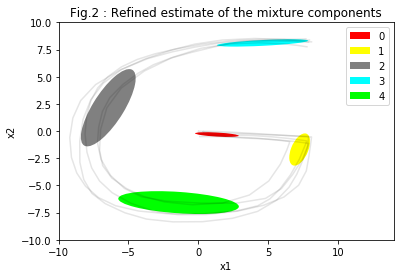

In [21]:
print('Initial probability distribution of the mixture components:')
print(hmm.weights_)
print('')

print('Transition matrix:')
print(hmm.Trans_)
print('')

#plot the mixture components
fig,ax = plt.subplots()
plot_GMM(hmm.means_, hmm.covariances_,ax,labels=['0','1','2','3','4','5'],colors=colors)
plt.axis([-10,14,-10,10])
plt.legend(loc='best')

#plot data
for data_i in data:
    plt.plot(data_i[:,0], data_i[:,1],'-k', alpha=0.1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Fig.2 : Refined estimate of the mixture components')
plt.show()

### Find the optimal sequence using Viterbi algorithms

Given a sequence of observations $\{x_t\}_{t=1}^{T}$, we can calculate the most probable sequence of mixture components that the observations belong to, using Viterbi algorithms.

In [22]:
data_index = 2 #select the sample index
opt_seq = hmm.viterbi(hmm.xs[data_index])
print('The optimal sequence for the given trajectory is:')
print(opt_seq)

The optimal sequence for the given trajectory is:
[3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0]


#### Compare the optimal sequence with Fig. 2. Does the sequence make sense?